# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [1]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

## Generating the data

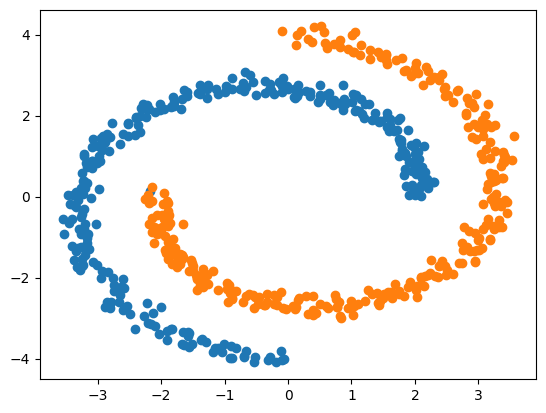

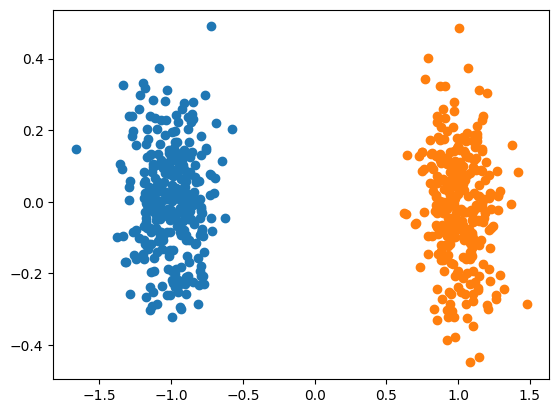

Signature: worst_case_blob(num_samples, delta=5)
Docstring:
Generates a single blob.

:param num_samples: number of samples to create in the blob
:param delta:
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      d:\documents\scolaires\mva\graphs\practicals\01_spectral_clustering\generate_data.py
Type:      function

In [2]:
# Example

for fn in [two_moons, blobs]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [74]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.zeros((n, n))

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        ####
        for i in range(n):
            for j in range(n):
                if i != j:
                    similarities[i, j] = np.exp(-np.linalg.norm(X[i] - X[j]) ** 2 / (2 * var))
        W = similarities
        W[W < eps] = 0
        ####

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        ####
        for i in range(n):
            for j in range(n):
                if i != j:
                    similarities[i, j] = np.exp(-np.linalg.norm(X[i] - X[j]) ** 2 / (2 * var))
        
        for i in range(n):
            neighbors = np.argsort(similarities[i])[-(k + 1):-1]
            
            for j in neighbors:
                W[i, j] = similarities[i, j]
        
        W = np.maximum(W, W.T)
        ####


    return W


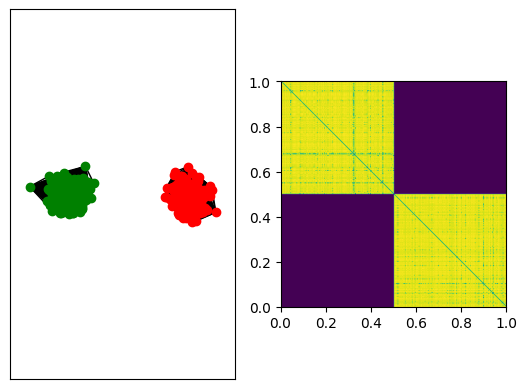

In [4]:
# Example

# W = build_similarity_graph(X, k=10)
W = build_similarity_graph(X, eps=0.8)
# W[0, 599] = 1    # add two placeholder edges to reproduce example picture
# W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [5]:
import numpy as np

def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    # Degree matrix
    D = np.diag(np.sum(W, axis=1))

    if laplacian_normalization == 'unn':
        # Unnormalized Laplacian
        L = D - W

    elif laplacian_normalization == 'sym':
        # Symmetric normalized Laplacian
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
        L = np.eye(W.shape[0]) - D_inv_sqrt @ W @ D_inv_sqrt

    elif laplacian_normalization == 'rw':
        # Random-walk normalized Laplacian
        D_inv = np.diag(1.0 / np.diag(D))
        L = np.eye(W.shape[0]) - D_inv @ W

    else:
        raise ValueError("laplacian_normalization must be 'unn', 'sym', or 'rw'")

    return L


## Clustering

In [175]:
import scipy
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    E, U = scipy.linalg.eig(L)
    E = np.real(E)  # Take the real part of eigenvalues
    U = np.real(U)  # Take the real part of eigenvectors
    
    idx = np.argsort(E)
    E = E[idx]
    U = U[:, idx]

    if chosen_eig_indices is None:
        chosen_eig_indices = range(1, num_classes+1)
    selected_U = U[:, chosen_eig_indices]

    row_norms = np.linalg.norm(selected_U, axis=1, keepdims=True)
    eps = 1e-15
    normalized_U = selected_U / (row_norms + eps)

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    kmeans = KMeans(n_clusters=num_classes, random_state=42)
    Y = kmeans.fit_predict(normalized_U)
    # Y = kmeans.fit_predict(selected_U)

    return Y

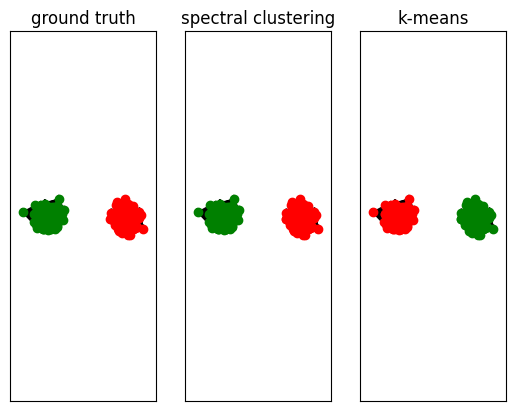

In [7]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [8]:
def parameter_sensitivity(parameter_type='k', parameter_candidate=range(5, 30), num_samples=500, var=1.0, laplacian_normalization='unn', chosen_eig_indices=None):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """

    """
    Choose parameters
    """

    """
    Choose candidate parameters
    """
    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()

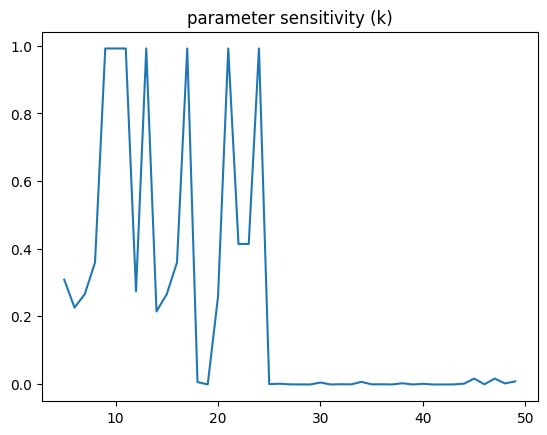

In [9]:
parameter_sensitivity(parameter_type='k', parameter_candidate=range(5, 50), num_samples=500, 
                      var=1.0, laplacian_normalization='unn', chosen_eig_indices=None)

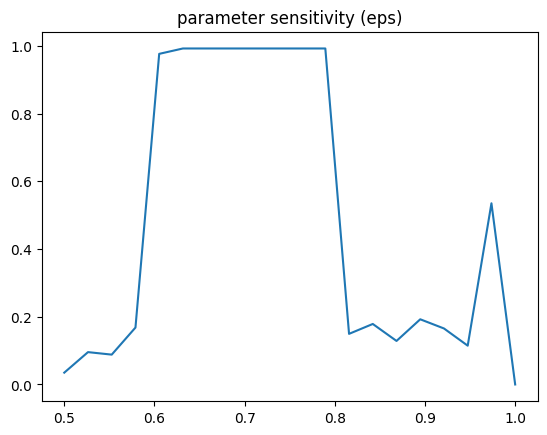

In [10]:
parameter_sensitivity(parameter_type='eps', parameter_candidate=np.linspace(0.5, 1.0, 20),
                      num_samples=500, 
                      var=1.0, laplacian_normalization='unn', chosen_eig_indices=None)

## Image segmentation

In [158]:
def image_segmentation(input_img='four_elements.bmp', var=1.0, k=50, laplacian_normalization='unn', chosen_eig_indices=None, num_classes=5):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """

    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

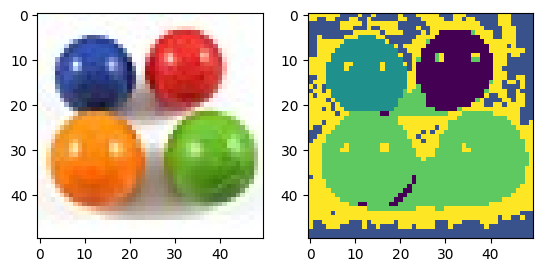

In [12]:
image_segmentation()

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

The `delta` parameter in the `worst_case_blob` function controls how far a single outlier point is placed relative to the main blob of points. A larger `delta` places the outlier farther from the main cluster, creating a more extreme "worst-case" scenario for clustering algorithms. This setup is used to test the robustness of algorithms in handling outliers.

In [13]:
worst_case_blob?

Signature: worst_case_blob(num_samples, delta=5)
Docstring:
Generates a single blob.

:param num_samples: number of samples to create in the blob
:param delta:
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      d:\documents\scolaires\mva\graphs\practicals\01_spectral_clustering\generate_data.py
Type:      function

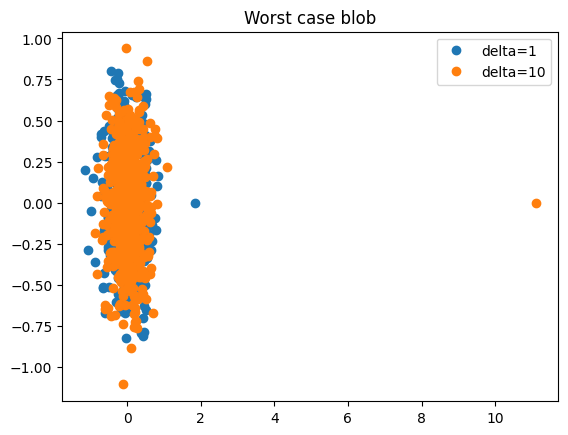

In [23]:
X, Y = worst_case_blob(num_samples=600, delta=1)
plot_clusters(X, Y, fignum=str(fn))

X, Y = worst_case_blob(num_samples=600, delta=10)
plot_clusters(X, Y, fignum=str(fn))

plt.legend(['delta=1', 'delta=10'])
plt.title('Worst case blob')
plt.show()

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

1. **Observations**:
   - **Too small $\epsilon$**: Graph is disconnected, affecting clustering quality.
   - **Too large $\epsilon$**: Over-connects points, reducing contrast in weights.

2. **When it's a bad idea**:
   - High-dimensional data or datasets with outliers (e.g., large `delta` in `worst_case_blob`).
   - Non-uniform densities.



In [24]:
min_span_tree?

Signature: min_span_tree(W)
Docstring:
:param W: (n x n) adjacency matrix representing the graph
:return: T: (n x n) matrix such that T[i,j] = True if the edge (i, j) is in the min spanning tree, and
            T[i, j] = False otherwise
File:      d:\documents\scolaires\mva\graphs\practicals\01_spectral_clustering\utils.py
Type:      function

Graph connected with eps = 0.01


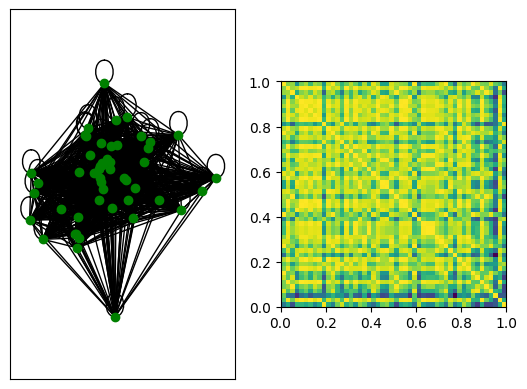

Graph connected with eps = 0.1


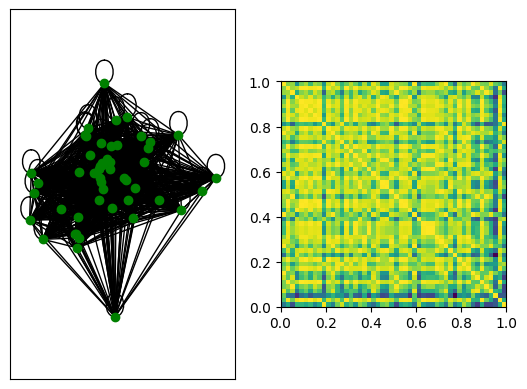

Graph connected with eps = 0.5


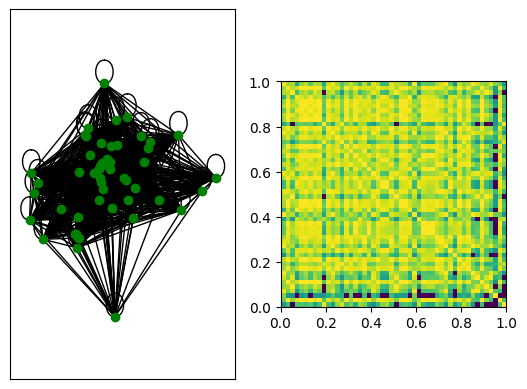

Graph disconnected with eps = 1.0
Graph disconnected with eps = 2.0
Graph disconnected with eps = 5.0


In [62]:
num_samples = 50
X, Y = worst_case_blob(num_samples=num_samples, delta=0.1)

eps_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
for eps in eps_values:
    W = build_similarity_graph(X, eps=eps)
    T = min_span_tree(W)
    
    if np.sum(T) == num_samples - 1:
        print(f"Graph connected with eps = {eps}")
        plot_graph_matrix(X, Y, W)
    else:
        print(f"Graph disconnected with eps = {eps}")

Graph connected with eps = 0.01


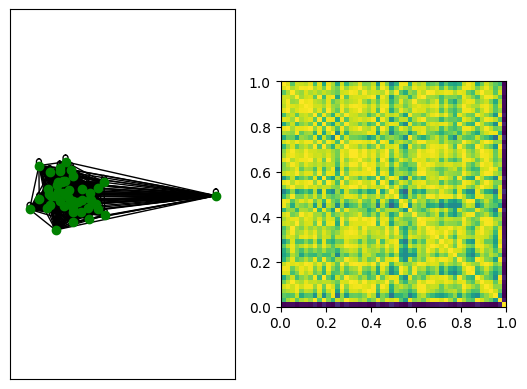

Graph connected with eps = 0.1


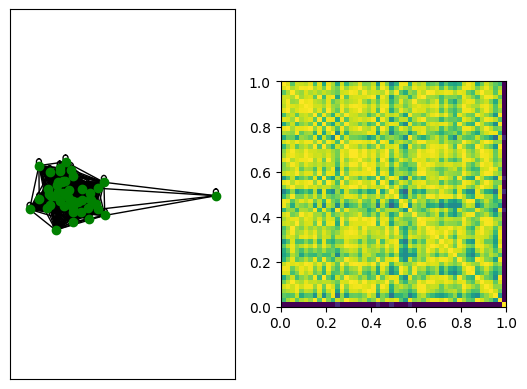

Graph disconnected with eps = 0.5
Graph disconnected with eps = 1.0
Graph disconnected with eps = 2.0
Graph disconnected with eps = 5.0


In [ ]:
num_samples = 50
X, Y = worst_case_blob(num_samples=num_samples, delta=2)

eps_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
for eps in eps_values:
    W = build_similarity_graph(X, eps=eps)
    T = min_span_tree(W)
    
    if np.sum(T) == num_samples - 1:
        print(f"Graph connected with eps = {eps}")
        plot_graph_matrix(X, Y, W)
    else:
        print(f"Graph disconnected with eps = {eps}")

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

1. **Importance of a Connected Graph**:
   - Yes, it is crucial for spectral clustering to have a connected graph. The graph Laplacian assumes all points are part of a single structure, and disconnected components lead to degenerate eigenvalues and poor clustering results.

2. **Comparison: k-NN vs. $\epsilon$-Graphs**:
   - **k-NN Graphs**:
     - Ensures connectivity more easily because each node connects to its nearest `k` neighbors.
     - Adapts to local density, making it suitable for datasets with varying density.
     - Requires tuning `k` to balance sparsity and connectivity.
   - **$\epsilon$-Graphs**:
     - Harder to ensure connectivity since it uses a global threshold for distances.
     - Sensitive to scale: small $\epsilon$ leads to disconnections, large $\epsilon$ over-connects the graph.
     - Struggles with outliers and non-uniform densities.


k-NN graph connected: True
Epsilon graph connected: True


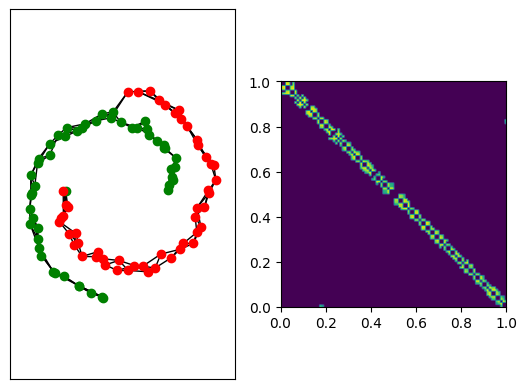

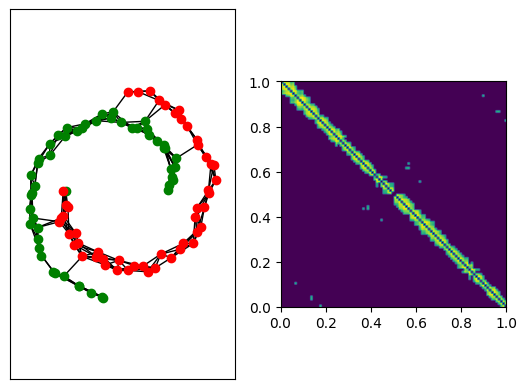

In [83]:
# Generate data
num_samples = 100
X, Y = two_moons(num_samples=num_samples)

# Build k-NN graph
k = 3
W_knn = build_similarity_graph(X, k=k)
T_knn = min_span_tree(W_knn)

# Build epsilon graph
eps = 0.6
W_eps = build_similarity_graph(X, eps=eps)
T_eps = min_span_tree(W_eps)

# Check connectivity
print("k-NN graph connected:", np.sum(T_knn) == num_samples - 1)
print("Epsilon graph connected:", np.sum(T_eps) == num_samples - 1)

# Visualize both graphs
plot_graph_matrix(X, Y, W_knn)
plot_graph_matrix(X, Y, W_eps)


### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

#### Motivation for Eigenvector Choice:
- The first eigenvector corresponds to the trivial eigenvalue $ \lambda_0 = 0 $, which is constant across all points and carries no clustering information.
- The subsequent eigenvectors ($ \lambda_1, \lambda_2, \dots $) capture meaningful structural information about the graph. Specifically, for $ k $-clusters, the eigenvectors associated with the smallest $ k $ non-zero eigenvalues provide the low-dimensional embedding for clustering.

#### Interpretation:
- **Spectral Clustering ARI (0.88)**: Captures global structure well, leveraging the graph's connectivity. Slightly less effective here because the blobs are simple and well-separated, where spectral clustering's strengths (handling complex geometries) are less needed.
- **K-Means ARI (0.91)**: Performs better because blobs are Gaussian-distributed (convex shape) and Euclidean distance is sufficient to separate them. No additional graph structure is required.

#### Key Insight:
- Spectral clustering shines in datasets with complex, non-convex cluster shapes or varying densities. Here, the Gaussian blobs make k-means naturally more effective.

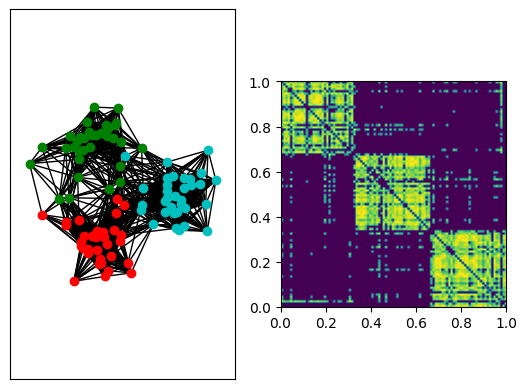

Signature: blobs(num_samples, n_blobs=2, blob_var=0.15, surplus=0)
Docstring:
Creates N gaussian blobs evenly spaced across a circle.

:param num_samples: number of samples to create in the dataset
:param n_blobs:      how many separate blobs to create
:param blob_var:    gaussian variance of each blob
:param surplus:     number of extra samples added to first blob to create unbalanced classes
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      d:\documents\scolaires\mva\graphs\practicals\01_spectral_clustering\generate_data.py
Type:      function

In [123]:
blobs?
num_classes = 3
X, Y = blobs(num_samples=100, n_blobs=num_classes, blob_var=0.4)
W = build_similarity_graph(X, eps=0.6)
plot_graph_matrix(X, Y, W)

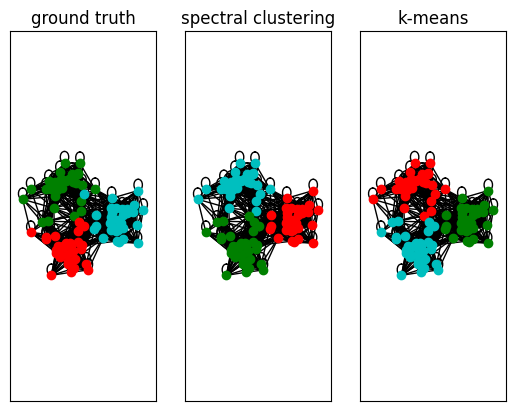

Adjusted Rand Index: Spectral Clustering: 0.8843845772696408, KMeans: 0.9118559824691342


In [130]:
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)

plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

perf_spec_clust = skm.adjusted_rand_score(Y, Y_rec)
perf_kmeans = skm.adjusted_rand_score(Y, KMeans(num_classes).fit_predict(X))

print(f"Adjusted Rand Index: Spectral Clustering: {perf_spec_clust}, KMeans: {perf_kmeans}")


### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

#### Choosing Eigenvectors:
- When the graph has 2 disconnected components, the first two eigenvalues of $L$ are 0.
- The **first eigenvector ($\lambda_0$)** is constant and irrelevant for clustering.
- The **second eigenvector ($\lambda_1$)** differentiates the two components by assigning constant but distinct values to each.

#### Motivation:
- For disconnected components, eigenvectors corresponding to 0 eigenvalues directly indicate cluster membership. Using the second eigenvector ($\lambda_1$) alone suffices to separate the components.

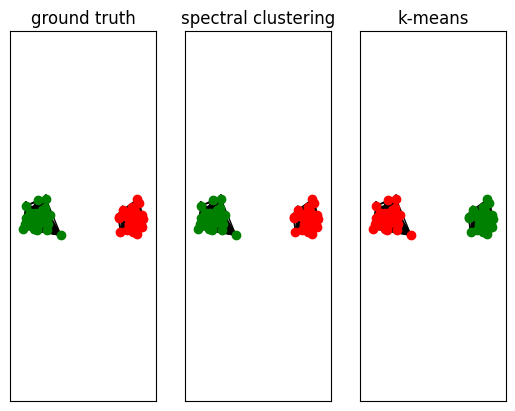

In [121]:
X, Y = blobs(num_samples=100, n_blobs=2)
W = build_similarity_graph(X, eps=0.6)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=2)
plot_clustering_result(X, Y, L, Y_rec, KMeans(2).fit_predict(X))


### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

#### Strategy for Choosing Eigenvectors
When `chosen_eig_indices=None`, and **`num_classes` is given**, the eigenvectors corresponding to the **first `num_classes` smallest non-zero eigenvalues** are selected. 

- The first eigenvector (associated with $\lambda_0 = 0$) is excluded as it is constant and does not provide clustering information.
- The next $ k = \text{num\_classes} $ eigenvectors encode the structural separation in the graph and are used for clustering.

#### Motivation
- The eigenvectors corresponding to the smallest eigenvalues (beyond the trivial 0 eigenvalue) represent the low-dimensional embedding of the data that best preserves the graph structure. This is the essence of spectral clustering.

#### Choosing the number of clusters

If we have to choose the number of clusters, we can use the eigengap heuristic, which suggests selecting the number of clusters as the number of eigenvectors corresponding to the largest gap in eigenvalues. This gap indicates a significant change in the graph structure, often associated with cluster boundaries.
$$
\text{eigengap} = \lambda_{k+1} - \lambda_k
$$
$$
\text{num\_clusters} = \underset{k}{ \text{argmax}} \left( \lambda_{k+1} - \lambda_k \right)
$$



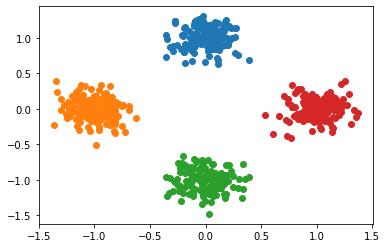

In [16]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)

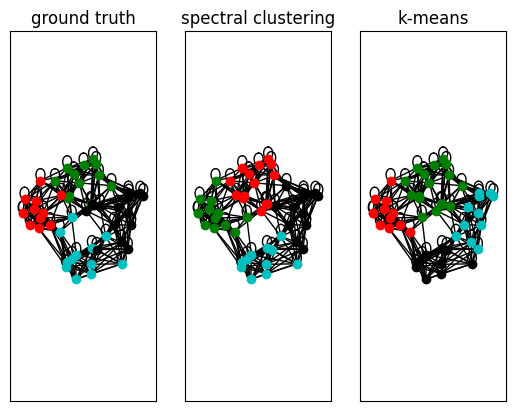

Adjusted Rand Index: 0.6494539882397466 (spectral clustering), 0.6142325663146485 (KMeans)


In [135]:
X, Y = blobs(num_samples=50, n_blobs=4, blob_var=0.4)
W = build_similarity_graph(X, k=10)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=4)
plot_clustering_result(X, Y, L, Y_rec, KMeans(4).fit_predict(X))
ari = skm.adjusted_rand_score(Y, Y_rec)
ari_kmeans = skm.adjusted_rand_score(Y, KMeans(4).fit_predict(X))
print(f"Adjusted Rand Index: {ari} (spectral clustering), {ari_kmeans} (KMeans)")

#### Observations:
1. **Low Variance**:
   - Spectral clustering works well, as blobs are distinct, and eigenvectors effectively capture cluster separation.

2. **High Variance**:
   - As variance increases, clusters overlap, and the graph's structure becomes less clear. This weakens the separability of eigenvectors, leading to poorer clustering.
   - The overlap may cause `k-means` on the spectral embedding to assign points incorrectly to clusters.

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

#### Method Used:
- **k-means** was used to assign clusters from the eigenvector matrix.

#### Thresholding vs. K-Means:
1. **Thresholding**:
   - Best for **disconnected graphs** or **clearly separated clusters**, as eigenvectors naturally align with components.
   - Struggles with overlapping or continuous cluster boundaries.

2. **K-Means**:
   - Preferred for **connected graphs** or **overlapping clusters**, as it can flexibly partition points in the spectral embedding.
   - Requires well-formed embeddings to perform effectively.

#### Recommendation:
- Use **thresholding** for clean, disconnected clusters and **k-means** for general cases or connected graphs.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

#### Observations:
- **K-Means**:
  - Struggles with the non-convex structure of `two_moons` because it relies on Euclidean distances, which cannot effectively separate the intertwined shapes.
  - Results in poor clustering where points from one moon are assigned to the other.

- **Spectral Clustering**:
  - Handles the non-convex structure well by building a graph representation of the data using a similarity measure. The graph Laplacian captures the structure of the two moons.
  - Eigenvectors provide a low-dimensional embedding where the moons become linearly separable, leading to accurate clustering.

#### Explanation:
- The **graph structure** in spectral clustering enables it to capture the non-linear relationships between points, preserving the shape of the moons. K-means, lacking this ability, fails to account for the curved boundaries.

#### Conclusion:
Spectral clustering significantly outperforms k-means on `two_moons` because it leverages the graph structure to capture non-linear relationships, while k-means fails due to its reliance on Euclidean distance.

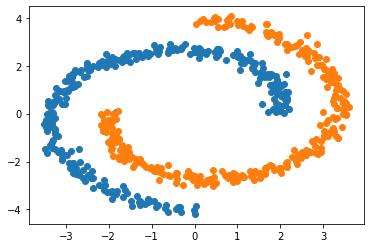

In [18]:
two_moons?
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

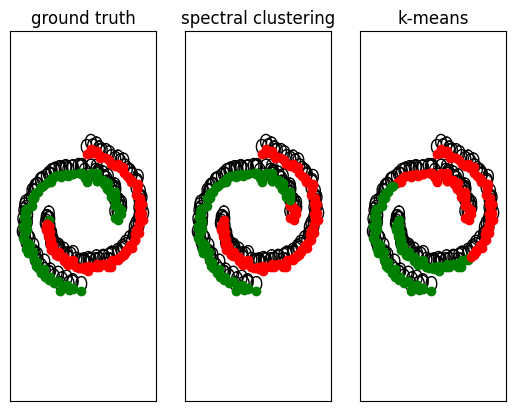

Adjusted Rand Index: Spectral Clustering = 0.7732742989188562, K-Means = -0.004949492449751288


In [144]:
X, Y = two_moons(num_samples=200, moon_var=0.01)
W = build_similarity_graph(X, k=2)
L = build_laplacian(W)
Y_spectral = spectral_clustering(L, num_classes=2)
Y_kmeans = KMeans(n_clusters=2, random_state=42).fit_predict(X)
plot_clustering_result(X, Y, L, Y_spectral, Y_kmeans)
ari_spectral = skm.adjusted_rand_score(Y, Y_spectral)
ari_kmeans = skm.adjusted_rand_score(Y, Y_kmeans)
print(f"Adjusted Rand Index: Spectral Clustering = {ari_spectral}, K-Means = {ari_kmeans}")


### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

#### Observations:
- **Normal Laplacian**:
  - Struggles with the `point_and_circle` dataset due to the imbalance in density (dense point vs. sparse circle).
  - Leads to less accurate clustering.

- **Random-Walk Laplacian**:
  - Normalizes by node degrees, making it robust to density imbalances.
  - Better separates the point and circle clusters.

#### Explanation:
- The **normal Laplacian** assumes balanced densities, while the **random-walk Laplacian** adjusts for varying densities, preserving the graph's structure for imbalanced clusters.

#### Conclusion:
The random-walk Laplacian performs better for imbalanced clusters like `point_and_circle`.

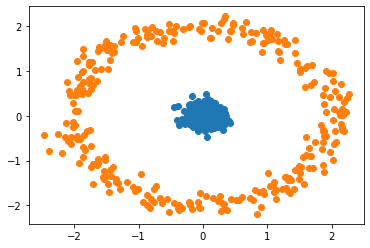

In [3]:
point_and_circle?
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

Point and circle data L_normal


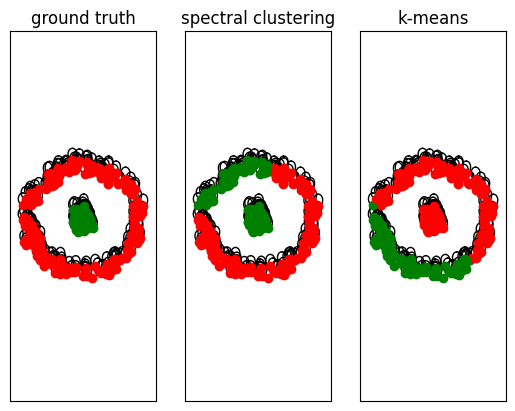

Point and circle data L_rw


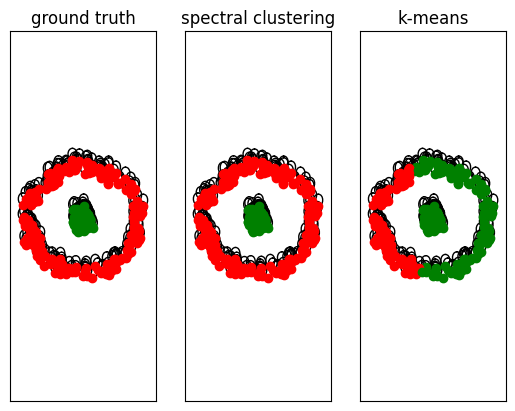

ARI: Normal Laplacian = 0.5029590481006401, Random-Walk Laplacian = 1.0


In [ ]:
X, Y = point_and_circle(num_samples=400)
W = build_similarity_graph(X, k=3)
L_normal = build_laplacian(W, laplacian_normalization='unn')
Y_normal = spectral_clustering(L_normal, num_classes=2)

L_rw = build_laplacian(W, laplacian_normalization='rw')
Y_rw = spectral_clustering(L_rw, num_classes=2)


print("Point and circle data L_normal")
plot_clustering_result(X, Y, L_normal, Y_normal, kmeans_labels=KMeans(2).fit_predict(X))

print("Point and circle data L_rw")
plot_clustering_result(X, Y, L_rw, Y_rw, kmeans_labels=KMeans(2).fit_predict(X))

ari_normal = skm.adjusted_rand_score(Y, Y_normal)
ari_rw = skm.adjusted_rand_score(Y, Y_rw)
print(f"ARI: Normal Laplacian = {ari_normal}, Random-Walk Laplacian = {ari_rw}")


### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

#### Stability Observations:
1. **Varying $\epsilon$**:
   - **Small $\epsilon$**: Graph is disconnected, causing unstable results.
   - **Large $\epsilon$**: Over-connected graph smooths out clusters.
   - **Stable Range**: Occurs when $\epsilon$ balances sparsity and connectivity.

2. **Varying $k$**:
   - **Small $k$**: Under-connected graph fails to capture cluster structure.
   - **Large $k$**: Over-connected graph reduces clustering accuracy.
   - **Stable Range**: Found with moderate $k$, ensuring local connectivity.

#### Conclusion:
Spectral clustering is sensitive to $\epsilon$ and $k$, with stability requiring balanced graph connectivity.

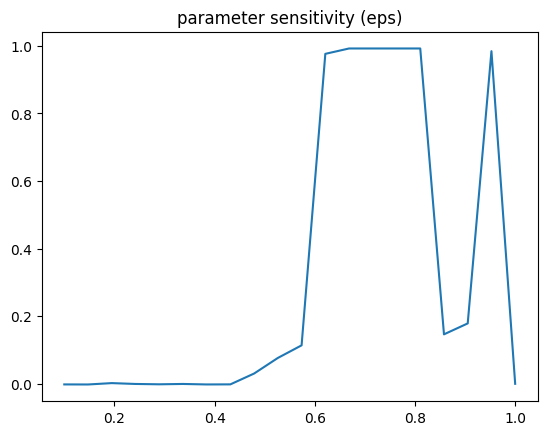

In [156]:
# Sensitivity to epsilon
parameter_sensitivity(parameter_type='eps', parameter_candidate=np.linspace(0.1, 1.0, 20), 
                      num_samples=500, var=1.0, laplacian_normalization='unn')


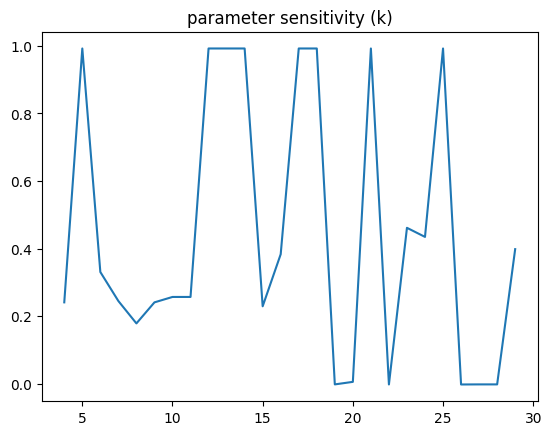

In [157]:
# Sensitivity to k
parameter_sensitivity(parameter_type='k', parameter_candidate=range(4, 30), 
                      num_samples=500, var=1.0, laplacian_normalization='unn')

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

#### Evaluation Without True Labels:
- Use **unsupervised metrics** like:
  - **Silhouette Score**: Measures cluster compactness and separation.
  - **Davies-Bouldin Index**: Evaluates intra-cluster similarity and inter-cluster separation.
  - **Modularity** (for graph-based clustering): Assesses the quality of the graph partition.


### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

#### Design Choices:
1. **Graph Type**:
   - Used **k-NN graph** because it is robust to local density variations and ensures connectivity.
   - $k = 50$: Chosen to balance connectivity without over-smoothing.

2. **Pre-Processing**:
   - Normalized pixel values to [0, 1] for uniformity.
   - Represented each pixel by its 3 RGB values, treating the image as a 2D dataset.

3. **Laplacian**:
   - Used the **unnormalized Laplacian** as it performs well when the graph is balanced (e.g., well-separated image regions).

#### Results:
- **Four Elements**:
  - Successfully segmented the image into its four distinct color regions.
- **Fruit Salad**:
  - Clustered regions based on color similarity; however, overlapping or blended areas caused minor inaccuracies.

#### Failure Mode:
- **Blended Colors**:
  - For images with smooth transitions (e.g., gradients), the algorithm struggles to identify sharp boundaries, leading to poorly defined clusters.
- **High $k$** or **high variance**:
  - Over-smoothing in the similarity graph reduces the distinction between clusters, leading to less accurate segmentation.


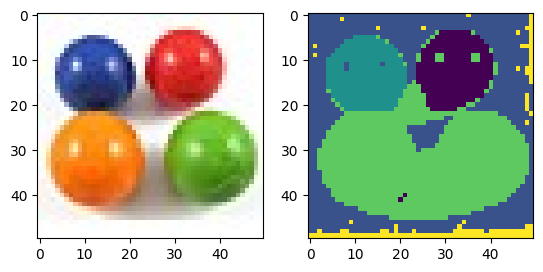

In [160]:
image_segmentation(input_img='four_elements.bmp', var=1.0, k=20, laplacian_normalization='unn', chosen_eig_indices=None, num_classes=5)

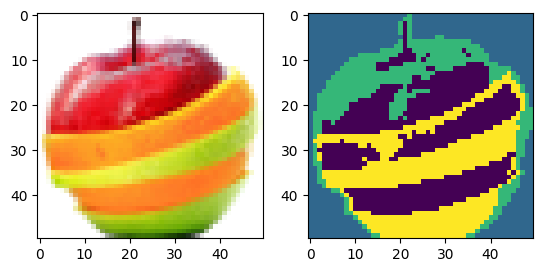

In [179]:
image_segmentation(input_img='fruit_salad.bmp', var=1.0, k=10, laplacian_normalization='unn', chosen_eig_indices=None, num_classes=4)

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

#### Two Techniques to Reduce Cost:

1. **Downsampling the Image**:
   - **What**: Reduce the resolution of the image (e.g., resizing to $ 100 \times 100 $) before constructing the similarity graph.
   - **Why**: Reduces the number of nodes in the graph, scaling down memory and computation cost.
   - **Impact**: Preserves large-scale structure but may lose fine details in segmentation.

2. **Sparse Graphs (Approximation)**:
   - **What**: Use a **k-NN graph** instead of a full similarity graph.
     - Only connect each pixel to its $ k $-nearest neighbors instead of all pixels.
   - **Why**: Reduces memory usage to $ O(kN) $ rather than $ O(N^2) $, where $ N $ is the number of pixels.
   - **Impact**: Maintains local similarity structure and reduces computational overhead without sacrificing accuracy significantly.



### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

In [171]:
from skimage.transform import resize
from sklearn.neighbors import kneighbors_graph
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

def build_sparse_similarity_graph(X, var=1.0, k=10):
    """
    Build a sparse k-NN similarity graph.

    :param X: Flattened image array (num_pixels, num_features).
    :param var: Variance for the Gaussian similarity function.
    :param k: Number of neighbors for k-NN graph.
    :return: Sparse similarity matrix (W).
    """
    knn_graph = kneighbors_graph(X, n_neighbors=k, mode='distance', include_self=False)
    distances = knn_graph.data
    weights = np.exp(-distances ** 2 / (2 * var))
    knn_graph.data = weights
    return knn_graph

def image_segmentation_large(
    input_img, 
    var=1.0, 
    k=10, 
    laplacian_normalization='unn', 
    num_classes=5, 
    resize_factor=1.0, 
    use_sparse=True
):
    """
    Perform spectral clustering on a large image with scalability modifications.

    :param input_img: Path to the image file.
    :param var: Variance for the similarity function.
    :param k: Number of neighbors for the sparse k-NN graph.
    :param laplacian_normalization: Type of Laplacian ('unn', 'sym', 'rw').
    :param num_classes: Number of clusters for segmentation.
    :param resize_factor: Resize factor (e.g., 0.5 reduces image size by half).
    :param use_sparse: Whether to use a sparse k-NN graph.
    """
    X = io.imread(input_img)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    # Resize image if needed
    if resize_factor < 1.0:
        new_size = (int(X.shape[0] * resize_factor), int(X.shape[1] * resize_factor))
        X = resize(X, new_size, anti_aliasing=True)

    im_side = X.shape[0]
    Xr = X.reshape(-1, 3)

    # Build graph (sparse or full)
    if use_sparse:
        W = build_sparse_similarity_graph(Xr, var=var, k=k)
    else:
        W = build_similarity_graph(Xr, var=var, k=0) 

    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, num_classes=num_classes)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    plt.title("Segmented Image")
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec, cmap='tab10')
    plt.show()


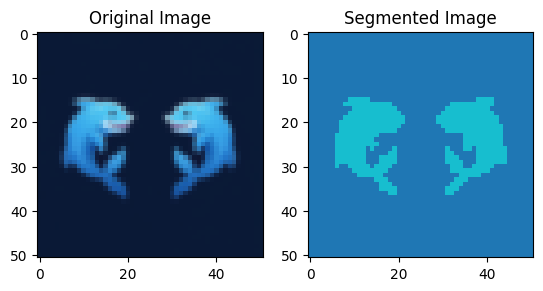

In [ ]:
image_segmentation_large(
    input_img='data/wales.jpg', 
    var=1.0, 
    k=10, 
    num_classes=2, 
    resize_factor=0.05,
    use_sparse=True
)